In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [101]:
def read_df():
    files = list(map(lambda x: f'data/{x}', os.listdir('data')))
    dfs = []
    for f in files:
        data = pd.read_csv(f, header=None, names=["frame#", "object_id","x_min", "y_min", "w", "h"])
        dfs.append(data)
    df = pd.concat(dfs, ignore_index=True)
    return df

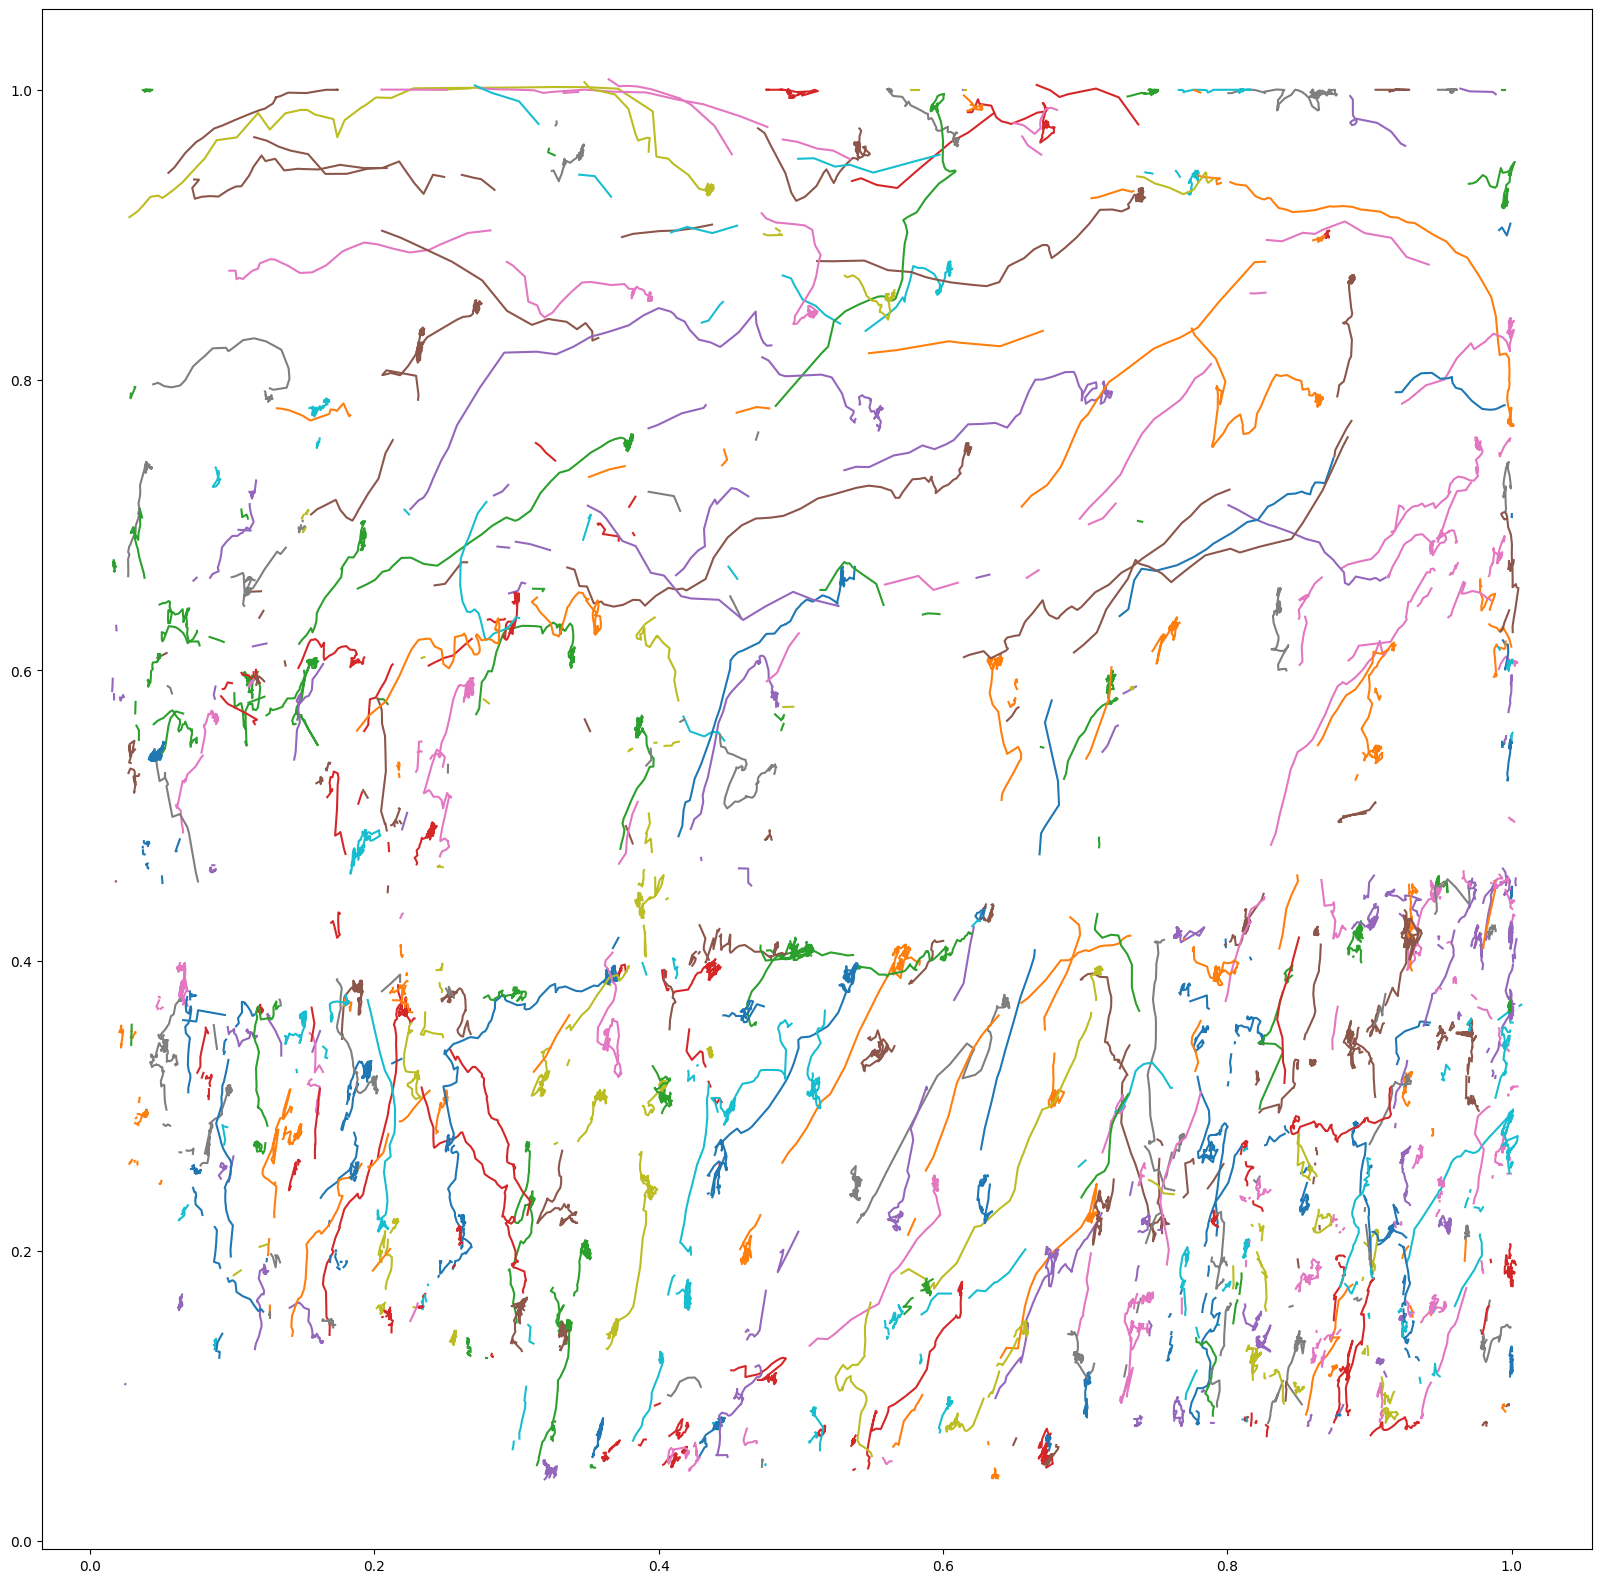

In [141]:
df = read_df()

frame_min, frame_max = df['frame#'].min(), df['frame#'].max()
n_frames = frame_max - frame_min + 1

plt.figure(figsize=(20, 20))

dfs = []
for i in range(df['object_id'].min(), df['object_id'].max()):
    complete_array = np.zeros((n_frames, 6))
    object_series = df[df['object_id'] == i].values
    n_available = object_series.shape[0]
    complete_array[:n_available, :] = object_series
    frames = list(complete_array[:n_available, 0])
    to_insert = np.array([f for f in range(frame_min, frame_max+1) if f not in frames])
    complete_array[n_available:, 0] = to_insert
    complete_array[n_available:, 1:] = np.nan
    col_df = pd.DataFrame(data=complete_array, columns=['frame#', 'object_id', 'x_min', 'y_min', 'w', 'h'])
    col_df.sort_values('frame#', inplace=True)
    col_df.interpolate(method='linear', limit_direction='both', limit=50)
    
    col_df["center_x"] = (col_df["x_min"] + 0.5 * col_df["w"])
    col_df["center_y"] = (col_df["y_min"] + 0.5 * col_df["h"])
    col_df["distance_to_corner"] = np.square(col_df["center_x"]**2 + col_df["center_y"]**2)
    
    # Assign region to each record
    width = 1
    height = 1
    s = 0.1
    col_df["region"] = col_df.center_x // s + (col_df.center_y // s) * (height / s)
    
    plt.plot(col_df["center_x"], col_df["center_y"])
    
    dfs.append(col_df)

df = pd.concat(dfs)
plt.show()

In [181]:
objects = dict()
df_dict = dict({
    'n_regions': [],
    'distance': [],
    'neighbors': [],
})

object_ids = df['object_id'].unique().astype('uint8')

for oid in object_ids:
    sub_df = df[df['object_id'] == oid]
    
    # Find the number of neighbors for each object
    neighbors = 0.0
    for index, row in sub_df.iterrows():
        region = row['region']
        frame = row['frame#']
        neighbors += df[(df['region'] == region) & (df['frame#'] == frame)]['object_id'].unique().shape[0]
    
    objects[oid] = {
        'n_regions': sub_df['region'].unique().shape[0],
        'distance': ((sub_df['center_x'].diff().fillna(0)**2 + sub_df['center_y'].diff().fillna(0)**2) ** 0.5).sum(),
        'neighbors': neighbors
    }
    
    df_dict['n_regions'].append(objects[oid]['n_regions'])
    df_dict['distance'].append(objects[oid]['distance'])
    df_dict['neighbors'].append(objects[oid]['neighbors'])

In [182]:
df_dict = pd.DataFrame(data=df_dict)
df_dict

,n_regions,distance,neighbors
0,5,0.396498,794.0
1,0,0.000000,0.0
2,2,0.218901,694.0
3,4,0.343171,261.0
4,5,1.016597,504.0
...,...,...,...
245,4,0.892330,611.0
246,2,0.360449,367.0
247,3,0.364032,558.0
248,1,0.056473,342.0


In [176]:
object_vectors = np.zeros((len(object_ids), 3), dtype='float32')

oid_uid_mapping = dict()
n = 0

for oid in object_ids:
    oid_uid_mapping[oid] = n
    object_vectors[n, 0] = objects[oid]['n_regions']
    object_vectors[n, 1] = objects[oid]['distance']
    object_vectors[n, 2] = objects[oid]['neighbors']
    n += 1

object_vectors.shape

(250, 3)

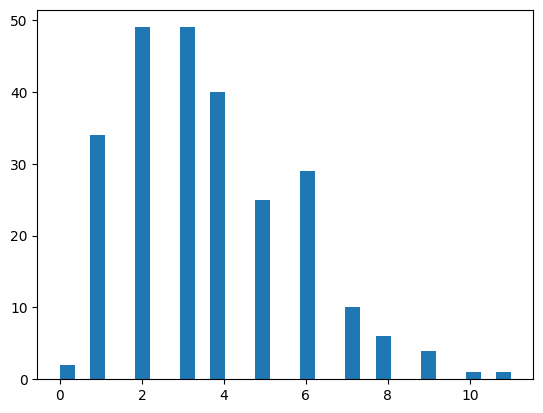

In [178]:
plt.hist(object_vectors[:, 0], bins=30)
plt.show()

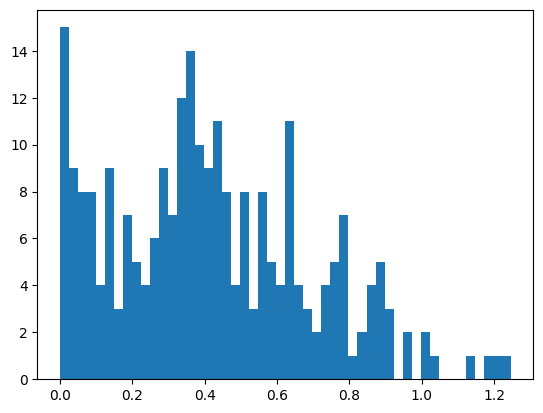

In [179]:
plt.hist(object_vectors[:, 1], bins=50)
plt.show()

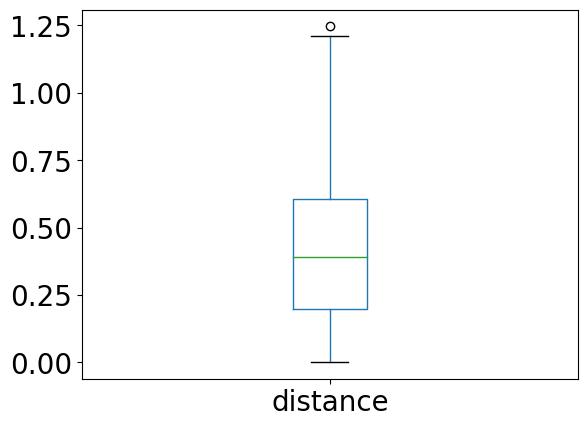

In [186]:
df_dict['distance'].to_frame().boxplot(grid=False, fontsize=20)
plt.show()

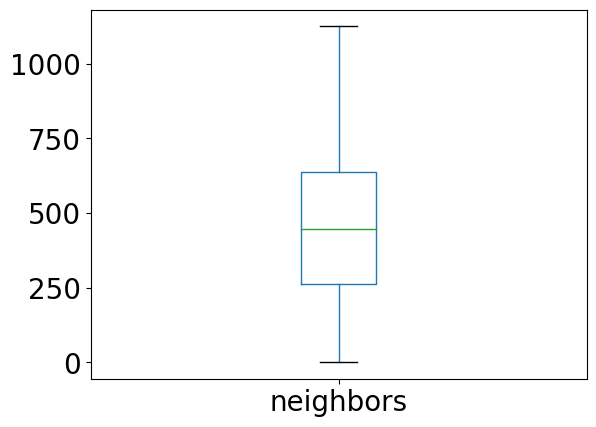

In [187]:
df_dict['neighbors'].to_frame().boxplot(grid=False, fontsize=20)
plt.show()

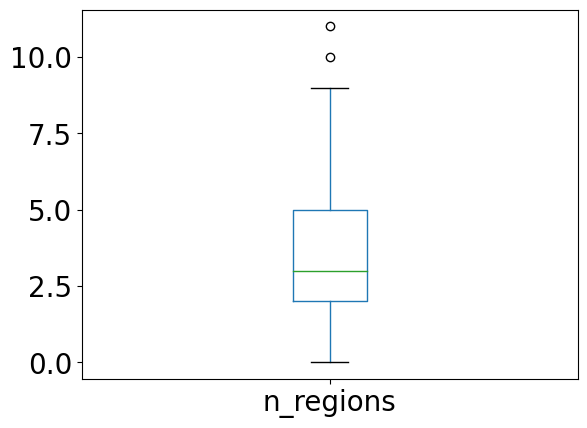

In [185]:
df_dict['n_regions'].to_frame().boxplot(grid=False, fontsize=20)
plt.show()

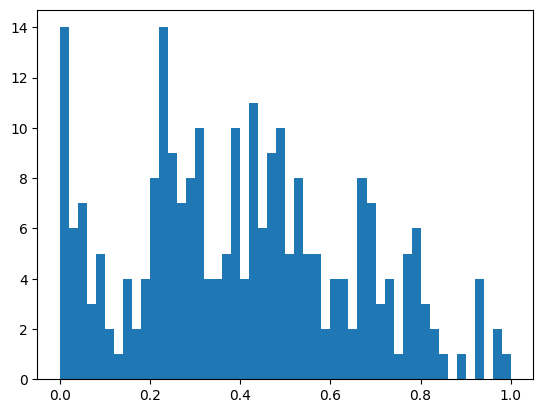

In [175]:
plt.hist(object_vectors[:, 2], bins=50)
plt.show()

## Clustering

In [168]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

In [171]:
from sklearn.cluster import KMeans

object_vectors[:, 0] = normalize(object_vectors[:, 0])
object_vectors[:, 1] = normalize(object_vectors[:, 1])
object_vectors[:, 2] = normalize(object_vectors[:, 2])

kmeans = KMeans(n_clusters=2).fit(object_vectors)
result = kmeans.predict(object_vectors)
np.unique(result, return_counts=True)

(array([0, 1], dtype=int32), array([165,  85]))

## Test :/

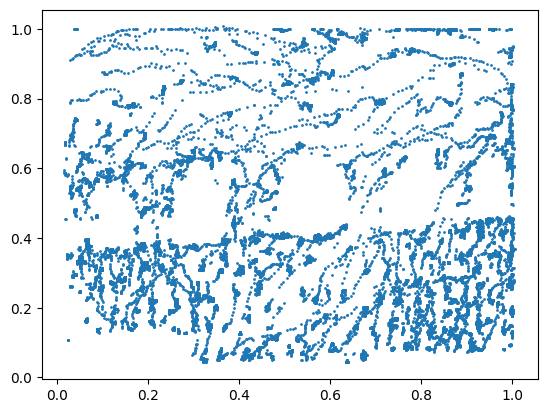

In [51]:
plt.scatter(df['center_x'], df['center_y'], s=1)

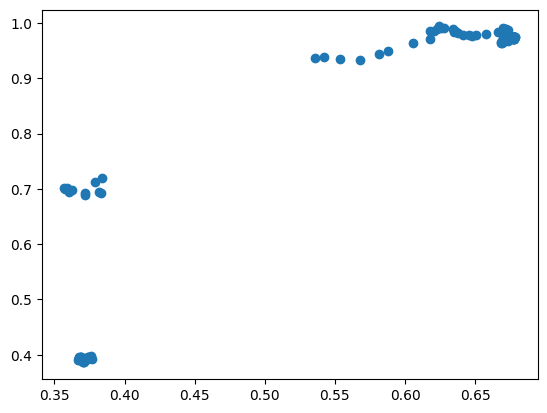

In [129]:
for i in range(1):
    object_one = df.query("object_id == " + str(4)).copy()
    object_one.sort_values('frame#', inplace = True)
    plt.scatter(object_one["center_x"], object_one["center_y"])        # plot x and y using default line style and color

In [52]:
df[df['frame#'].isin(np.arange(2, 346)) and df['object_id'].isin([4])]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [48]:
object_one[object_one['frame#'].isin(np.arange(2, 346)) and object_one['object_id'] == 4]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [31]:
object_one = df.query("object_id == " + str(4)).copy()
object_one.sort_values('frame#', inplace = True)

print(object_one.to_string())

       frame#  object_id     x_min     y_min         w         h  center_x  center_y  distance_to_corner
16662       2          4  0.635156  0.911111  0.072396  0.125926  0.671354  0.974074            1.958703
29461       3          4  0.635156  0.911111  0.072396  0.125926  0.671354  0.974074            1.958703
29323       4          4  0.634964  0.911111  0.072372  0.125926  0.671150  0.974074            1.957937
13249       5          4  0.634900  0.911774  0.071640  0.124600  0.670720  0.974074            1.956322
18137       6          4  0.634881  0.911352  0.072094  0.125443  0.670928  0.974074            1.957101
26661       7          4  0.634876  0.911198  0.072239  0.125752  0.670996  0.974074            1.957356
15977       8          4  0.634522  0.911141  0.072346  0.125867  0.670694  0.974074            1.956225
39527       9          4  0.634745  0.911119  0.072333  0.125910  0.670912  0.974074            1.957042
26104      10          4  0.634832  0.911111  0.072306 

In [37]:
df = pd.DataFrame({"A":[12, 4, 5, None, 1],
                   "B":[None, 2, 54, 3, None],
                   "C":[20, 16, None, 3, 8],
                   "D":[14, 3, None, None, 6]})
  
# Print the dataframe
df

SyntaxError: invalid character in identifier (924397748.py, line 2)

In [118]:
df = pd.DataFrame(
    {"A":[12, 4, 5, None, 1],"B":[None, 2, 54, 3, None],"C":[20, 16, None, 3, 8],"D":[14, 3, None, 3, 6]}
)

# Print the dataframe
df

,A,B,C,D
0,12.0,NaN,20.0,14.0
1,4.0,2.0,16.0,3.0
2,5.0,54.0,NaN,NaN
3,NaN,3.0,3.0,3.0
4,1.0,NaN,8.0,6.0


In [119]:
df.interpolate(method='linear', limit_direction='both', limit=5, inplace=True)

In [126]:
# Regions
df['D'].unique().shape[0]

3

In [112]:
df['D'].diff().abs().fillna(0).sum()

14.0

In [117]:
# Distance
((df['D'].diff().fillna(0)**2 + df['C'].diff().fillna(0)**2) ** 0.5).sum()

29.95666586227832